# homography matrix 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import cv2
from InverseForm import InverseNet
from pathlib import Path
import numpy as np

In [2]:
def plot(image):
    image = image.squeeze().detach().numpy()
    plt.imshow(image, cmap="gray")
    plt.show()

In [3]:
label_paths = sorted(list(Path("./labels/").glob("*")))

In [4]:
class BADataset(torch.utils.data.Dataset):
    def __init__(self, path_list, size=(224,224)):
        super().__init__()
        self.path_list = path_list
        self.size = size
    
    def load_image(self, path):
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image ,self.size)
        image = np.where(image>0, 1, 0)
        return image
    
    def to_tensor(self, image):
        image = torch.tensor(image, dtype=torch.float32)
        image = image.view(1,*self.size)
        return image

    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, idx):
        image_path = self.path_list[idx]
        image = self.load_image(image_path)
        image = self.to_tensor(image)
        return image

In [5]:
dataset = BADataset(label_paths)
image = dataset[0].squeeze()
image = np.array(image)

In [6]:
src = np.array([
    [1,1],
    [4,1],
    [4,4],
    [1,4]
])
dst = np.array([
    [1,1],
    [8,1],
    [8,8],
    [1,8]
])

In [7]:
def homography_matrix(src, dst):
    X = []
    for (x1, y1), (x2, y2) in zip(src, dst):
        X.append([x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2])
        X.append([0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2])
    X = np.array(X)
    y = dst.flatten()

    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    h = (Vt.T @ np.linalg.pinv(np.diag(S)) @ U.T) @ y
    H = np.vstack([h.reshape(-1, 1), 1]).reshape(3,3)
    return H

def apply_homography_matrix(src, matrix):
    src = np.array(src)
    dst_est = matrix @ np.vstack([src.reshape(-1, 1), 1])
    dst_est = (dst_est/dst_est[-1][0])[:-1]
    return dst_est.reshape(-1)
    

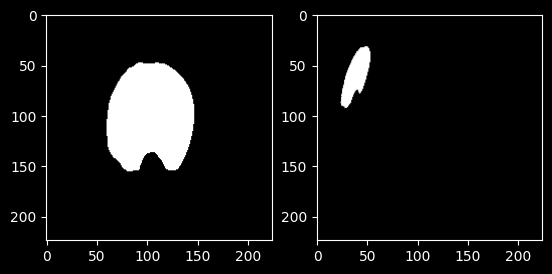

In [50]:
# 変換前と変換後の対応点
# Random source points in the image
src_points = np.random.randint(0, 224, (4, 2)).astype(np.float32)

# Random destination points in the image
dst_points = np.random.randint(0, 224, (4, 2)).astype(np.float32)

# ホモグラフィー行列の計算
H = homography_matrix(src_points, dst_points)
theta = np.deg2rad(10)

R = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0.01, 0, 1]
])
# 画像のサイズ（幅、高さ）
height, width = image.shape[:2]

# 画像の変換
transformed_img = cv2.warpPerspective(image, R, (width, height))
plt.subplot(121)
plt.imshow(image, cmap="gray")
plt.subplot(122)
plt.imshow(transformed_img,cmap="gray")
plt.show()